My own implementation of PINN to solve an equation using ODE.
Here is a useful resource with an example:
 https://vitalitylearning.medium.com/solving-a-first-order-ode-with-physics-informed-neural-networks-22e385f09d35

In [120]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [121]:
# -----
# Define Variables/Generate Fake Data/PINN class
# -----
# The function we are wanting to predict is f(x) = x^2

#seed for repeatable outputs when using randomness
np.random.seed(0) 
torch.manual_seed(0)

len_of_data_pts = 50
noise_level = 0.25
random_noise = (torch.randn(1,len_of_data_pts + 1) * noise_level) # random noise multipliers in a tensor shape 1 by len_of_data_pts

# x_inputs = [1,2,3,4,5,6,7,8,9,10]
#actual_outputs_20 = [1,4,9,16,25,36,49,64,81,100, 121, 144, 169, 196, 225, 256, 289, 324, 361, 400] 
#actual_outputs_10 = [1,4,9,16,25,36,49,64,81,100]
#acutal_outputs_5 = [1,4,9,16,25]
noisy_outputs = []
noisy_outputs_amnt = len_of_data_pts

for i in range (1, noisy_outputs_amnt + 1): # change depending on how many data points we want
    noisy_outputs.append(i**2 + random_noise[0,i])
#for i in range(len(noisy_outputs)):
#    print(noisy_outputs[i])

noisy_data_tensor = torch.tensor(noisy_outputs, dtype=torch.float32).view(-1,1)

# Create a numpy array of 10 evenly spaced numbers between 1 and 10 (inclusive) using linspace
x_min = 1.0
x_max = len_of_data_pts
n_data = len_of_data_pts
x_data = np.linspace(x_min, x_max, n_data) 
print(x_data)

# convert data into tensors, inputs our model can understand
x_data_tensor = torch.tensor(x_data, dtype=torch.float32, requires_grad=True).view(-1,1) #reshaping...

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()    # 5 layers including I/O
        self.fc1 = nn.Linear(1, 30)  
        self.activation1 = nn.LogSigmoid()        
        self.fc2 = nn.Linear(30, 30)
        self.activation2 = nn.LogSigmoid()
        self.fc3 = nn.Linear(30,30)
        self.activation3 = nn.LogSigmoid()
        self.fc4 = nn.Linear(30,30)
        self.activation4 = nn.LogSigmoid()
        self.fc5 = nn.Linear(30,1)
        
        
# make ReLu activation function in forward operation
    def forward(self, x): # x is the data we are passing through the layers
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.fc3(x)
        x = self.activation3(x)
        x = self.fc4(x)
        x = self.activation4(x)
        x = self.fc5(x)
        return x

#instantiate the model
model = PINN()

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50.]


In [122]:
# --- 
# Define auto-differentiation function (important)
# ---

# Computes dy/dx using PyTorch's autograd.
# y and x must be tensors with requires_grad=True for x

def auto_diff_dy_dx (x,y):
    return torch.autograd.grad(
        y, x,
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]

In [123]:
# -----
# Define loss functions and helper functions
# -----
# We are NOT dealing with any initial/boundary conditions
# Ground truth solution function is f(x) = x^2

# Create an instance of MSELoss
mse_loss_fn = nn.MSELoss()

# Lambdas (penalty weights, as in how much we want to weight each loss)
# lambda_physics = 1.0
# lambda_ode = 1.0

def true_solution(x):
    return x ** 2

def physics_loss_func(model, x, noisy_data): # loss from data vs. predicted
    pred_output = model(x)
    # Compute the MSE loss
    phys_loss = mse_loss_fn(pred_output, noisy_data)
    return phys_loss
    
def ode_loss_func(model, x):                                                    # use automatic differentiation here (need tensors)
    x = x.clone().detach().requires_grad_(True)                                 # Key line: detaches and reattaches gradients to ensure requires_grad_=True
    y = model(x)
    pred_dy_dx = auto_diff_dy_dx(x, y)
    
    true_dy_dx = 2 * x 
    ode_loss = mse_loss_fn(pred_dy_dx, true_dy_dx)
    
    print("pred_dy_dx:", pred_dy_dx.detach().numpy().flatten())
    print("true_dy_dx:", true_dy_dx.detach().numpy().flatten())
    print("difference:", (pred_dy_dx - true_dy_dx).detach().numpy().flatten())
    
    return ode_loss

def initial_condition_loss_func(model, x=torch.tensor(0, dtype=torch.float32).unsqueeze(0)): # value at y(0) = 0, the '0' needs to be in tensor form
    real_ic = torch.tensor(0, dtype=torch.float32).unsqueeze(0)
    pred_ic = model(x)
    ic_loss = mse_loss_fn(pred_ic, real_ic)
    return ic_loss
    
def total_loss_func(ode_loss, ic_loss, phys_loss, lambda_ode, lambda_ic, lambda_phys):
    tot_loss = (lambda_ode * ode_loss) + (lambda_ic * ic_loss) + (lambda_phys * phys_loss)
    return tot_loss

In [144]:
# -----
# Train the Model
# -----


# using Adam to optimize our PINN
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) # lr = learning rate = eta

epochs = 400

model.train()

for epoch in range(epochs): 
    
    # CRITICAL FIX: Zero the gradients before each training step
    optimizer.zero_grad()
    
    x_input = x_data_tensor.clone().detach().requires_grad_(True) # cloning x_data_tensor with requires_grad_(True) just to be safe.
    
    # compute losses --> total loss
    phys_loss = physics_loss_func(model, x_input, noisy_data_tensor) # if we don't want to deal with different data sizes, comment out
    ode_loss = ode_loss_func(model, x_input)
    ic_loss = initial_condition_loss_func(model)
    tot_loss = total_loss_func(ode_loss, ic_loss, phys_loss, lambda_ode=1.0, lambda_ic=0.0, lambda_phys=0.0) #lambdas adjust the weight of each loss value
    
    #Backpropagation
    tot_loss.backward() 
    optimizer.step()
    
    # Print the gradients
    if epoch & 10 == 0:
        print("Gradients:")
        for name, param in model.named_parameters():
            if param.grad is not None:
                print(f"  {name}.grad: {param.grad}")
            else:
                print(f"  {name}.grad: None (No gradient computed, perhaps due to no contribution to loss or requires_grad=False)")
        
    if epoch % 100 == 0:
        print(
            f"Epoch = {epoch}",
            f"Physics Loss = {phys_loss}",
            f"ODE Loss = {ode_loss}",
            f"Total Loss = {tot_loss}"
        )

pred_dy_dx: [ 1.9988737  4.001195   6.0000725  8.000942  10.000149  12.000391
 13.993929  16.000599  17.99009   20.026669  22.013672  23.988693
 25.97738   27.983963  30.000122  32.01454   34.019676  36.014297
 38.002655  39.991245  41.98536   43.987053  45.994843  48.004932
 50.012936  52.01545   54.011063  56.000908  57.988297  59.977783
 61.97363   63.978195  65.99104   68.00909   70.027374  72.04053
 74.04422   76.03638   78.01774   79.992065  81.96561   83.946075
 85.94087   87.9548    89.987595  92.031586  94.07048   96.079895
 98.029724  99.88826  ]
true_dy_dx: [  2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.  28.
  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.  56.
  58.  60.  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.  84.
  86.  88.  90.  92.  94.  96.  98. 100.]
difference: [-1.12628937e-03  1.19495392e-03  7.24792480e-05  9.42230225e-04
  1.48773193e-04  3.91006470e-04 -6.07109070e-03  5.98907471e-04
 -9.91058350e-03  2.66685486

[[1.0000000e+00]
 [9.1228657e+00]
 [2.5409828e+01]
 [4.9860889e+01]
 [8.2476051e+01]
 [1.2325532e+02]
 [1.7219867e+02]
 [2.2930614e+02]
 [2.9457767e+02]
 [3.6801334e+02]
 [4.4961313e+02]
 [5.3937689e+02]
 [6.3730487e+02]
 [7.4339691e+02]
 [8.5765314e+02]
 [9.8007324e+02]
 [1.1106576e+03]
 [1.2494061e+03]
 [1.3963187e+03]
 [1.5513954e+03]
 [1.7146361e+03]
 [1.8860406e+03]
 [2.0656096e+03]
 [2.2533428e+03]
 [2.4492400e+03]
 [2.6533013e+03]
 [2.8655266e+03]
 [3.0859160e+03]
 [3.3144695e+03]
 [3.5511868e+03]
 [3.7960686e+03]
 [4.0491145e+03]
 [4.3103242e+03]
 [4.5796982e+03]
 [4.8572368e+03]
 [5.1429390e+03]
 [5.4368052e+03]
 [5.7388359e+03]
 [6.0490303e+03]
 [6.3673892e+03]
 [6.6939116e+03]
 [7.0285977e+03]
 [7.3714482e+03]
 [7.7224634e+03]
 [8.0816426e+03]
 [8.4489863e+03]
 [8.8244932e+03]
 [9.2081650e+03]
 [9.6000000e+03]
 [1.0000000e+04]]


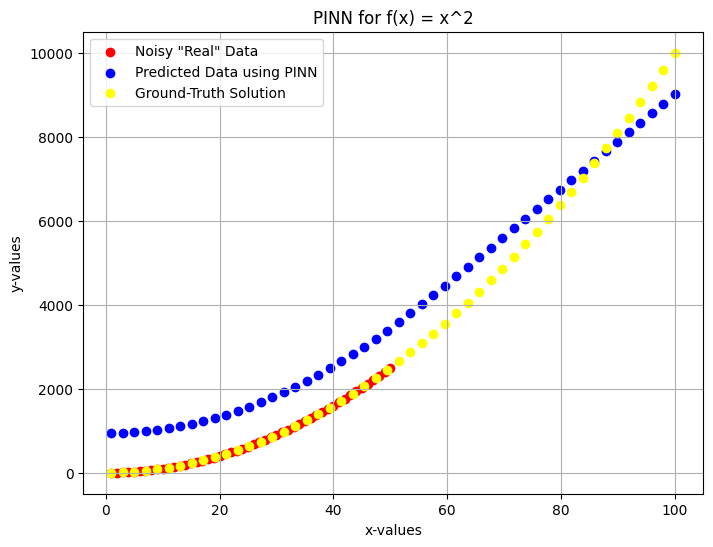

In [143]:
# -----
# Evaluate the Model and Plot
# -----
model.eval()


x_plot = np.linspace(x_min, 100, 50).reshape(-1, 1).astype(np.float32) # x-axis, values from x_min - x_max (change x-max to see more predictions)
x_plot_tensor = torch.tensor(x_plot, requires_grad=True)
y_pred_plot = model(x_plot_tensor).detach().numpy() # what does this do?

#True solution to compare on the graph
y_true_plot = true_solution(x_plot)
print(y_true_plot)

# Plot the results
plt.figure(figsize=(8,6))

# Plotting 3 graphs
plt.scatter(x_data, noisy_outputs, color='red', label='Noisy "Real" Data')
plt.scatter(x_plot, y_pred_plot, color='blue', label='Predicted Data using PINN')
plt.scatter(x_plot, y_true_plot,color='yellow', label='Ground-Truth Solution')

# Plot the dy_dx loss
# plt.scatter(x_plot, y_true_plot,color='purple', label='dy_dx loss')

plt.xlabel('x-values')
plt.ylabel('y-values')
plt.legend()
plt.title('PINN for f(x) = x^2')
plt.grid(True)
plt.show()


In [140]:
# --- Testing the model on inputs ----
model.eval()

input_value = 11.0

#input must be a tensor
# unsqueeze(0) adds a new dimension of size 1 at position 0. 
# If input_tensor was tensor(5.0), its shape was torch.Size([]) (0 dimensions)
# After unsqueeze(0), it becomes torch.Size([1])
model_input = torch.tensor(input_value, dtype=torch.float32).unsqueeze(0) 

predicted_output = model(model_input)

print(predicted_output)

print("\n")

# testing loop
for i in range(51):
    input_value = i
    model_input = torch.tensor(input_value, dtype=torch.float32).unsqueeze(0)
    predicted_output = model(model_input)
    print(f"input: {i} --> output: {predicted_output}")
    print(f"actual: {i ** 2}")
    #print("\n")
    
# starts falling off around 12

tensor([1056.7020], grad_fn=<ViewBackward0>)


input: 0 --> output: tensor([937.9600], grad_fn=<ViewBackward0>)
actual: 0
input: 1 --> output: tensor([936.4293], grad_fn=<ViewBackward0>)
actual: 1
input: 2 --> output: tensor([940.0226], grad_fn=<ViewBackward0>)
actual: 4
input: 3 --> output: tensor([944.1017], grad_fn=<ViewBackward0>)
actual: 9
input: 4 --> output: tensor([951.6505], grad_fn=<ViewBackward0>)
actual: 16
input: 5 --> output: tensor([960.1562], grad_fn=<ViewBackward0>)
actual: 25
input: 6 --> output: tensor([971.4780], grad_fn=<ViewBackward0>)
actual: 36
input: 7 --> output: tensor([984.4811], grad_fn=<ViewBackward0>)
actual: 49
input: 8 --> output: tensor([999.5567], grad_fn=<ViewBackward0>)
actual: 64
input: 9 --> output: tensor([1016.5809], grad_fn=<ViewBackward0>)
actual: 81
input: 10 --> output: tensor([1035.6361], grad_fn=<ViewBackward0>)
actual: 100
input: 11 --> output: tensor([1056.7020], grad_fn=<ViewBackward0>)
actual: 121
input: 12 --> output: tensor([1079.747

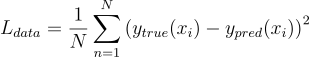